In [114]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.models import Sequential

In [115]:
TRAIN_DIR = '../data/processed/train/'
TEST_DIR = '../data/processed/test/'
VAL_DIR = '../data/processed/val/'
IMG_SIZE = (224,224)

In [116]:
BATCH_SIZE = 32

# Load the dataset without any predefined batch size
train_data = tf.keras.utils.image_dataset_from_directory(
    directory = TRAIN_DIR,
    labels='inferred',
    label_mode='int',
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,  # Resize images to standard size
    seed=42 
)

Found 125 files belonging to 2 classes.


In [117]:
test_data = keras.utils.image_dataset_from_directory(
    directory = TEST_DIR,
    labels = 'inferred',
    label_mode = 'int',
    color_mode = 'grayscale',
    batch_size = BATCH_SIZE,
    image_size=IMG_SIZE,  # Resize images to standard size
    seed=42 
)

Found 27 files belonging to 2 classes.


In [118]:
val_data = keras.utils.image_dataset_from_directory(
    directory = VAL_DIR,
    labels = 'inferred',
    label_mode = 'int',
    color_mode = 'grayscale',
    batch_size = BATCH_SIZE,
    image_size=IMG_SIZE,  # Resize images to standard size
    seed=42 
)

Found 27 files belonging to 2 classes.


In [119]:
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

In [120]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [121]:
# Class names
class_names = ['tumor','no_tumor']

In [122]:
# # Extract data from train dataset
# def extract_images_and_labels(dataset):
#     X, y = [], []
#     for image, label in dataset:
#         X.append(image.numpy())
#         y.append(label.numpy())
#     return np.array(X), np.array(y)

# # Assuming train_data is loaded correctly
# X_train, y_train = extract_images_and_labels(train_data)

In [123]:
# X_val, y_val = extract_images_and_labels(val_data)

In [124]:
# print(f'X shape: {X_train.shape}')
# print(f'y shape: {y_train.shape}')

In [125]:
# Use tf.data pipeline instead of manual extraction
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

In [126]:
model_file = "my_model.keras"

model = Sequential()
model.add(tf.keras.layers.Rescaling(1./255, input_shape=(224,224,1)))
model.add(Conv2D(32, (3,3), padding="Same", activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (5,5), padding="Same", activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(64, (3,3), padding="Same", activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (5,5), padding="Same", activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(128, (3,3), padding="Same", activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (5,5), padding="Same", activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [127]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [128]:
model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [129]:
model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_34 (Rescaling)    (None, 224, 224, 1)       0         
                                                                 
 conv2d_212 (Conv2D)         (None, 224, 224, 32)      320       
                                                                 
 batch_normalization_106 (B  (None, 224, 224, 32)      128       
 atchNormalization)                                              
                                                                 
 conv2d_213 (Conv2D)         (None, 224, 224, 32)      25632     
                                                                 
 max_pooling2d_106 (MaxPool  (None, 112, 112, 32)      0         
 ing2D)                                                          
                                                                 
 dropout_134 (Dropout)       (None, 112, 112, 32)    

In [130]:
# history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

In [131]:
# Train directly on the dataset instead of extracting
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5
)

Epoch 1/5
4/4 [==============================] - 46s 11s/step - loss: 17.6059 - accuracy: 0.4640 - val_loss: 0.6939 - val_accuracy: 0.4815
Epoch 2/5
4/4 [==============================] - 41s 11s/step - loss: 2.0420 - accuracy: 0.5360 - val_loss: 0.6924 - val_accuracy: 0.5185
Epoch 3/5
4/4 [==============================] - 41s 10s/step - loss: 1.7641 - accuracy: 0.4960 - val_loss: 0.6942 - val_accuracy: 0.4815
Epoch 4/5
4/4 [==============================] - 41s 11s/step - loss: 1.1811 - accuracy: 0.5120 - val_loss: 0.6931 - val_accuracy: 0.4815
Epoch 5/5
4/4 [==============================] - 41s 10s/step - loss: 1.0282 - accuracy: 0.5360 - val_loss: 0.6926 - val_accuracy: 0.5185


In [132]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test accuracy: {test_accuracy:.4f}")

# Generate predictions and confusion matrix
y_pred = []
y_true = []
for images, labels in test_data:
    predictions = model.predict(images)
    pred_classes = np.argmax(predictions, axis=1)
    y_pred.extend(pred_classes)
    y_true.extend(labels.numpy())

1/1 [==============================] - 3s 3s/step - loss: 0.6927 - accuracy: 0.5185
Test accuracy: 0.5185
1/1 [==============================] - 3s 3s/step


In [139]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.models import Sequential
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import os

# Create models directory if it doesn't exist
MODELS_DIR = os.path.join('..', 'src', 'models', 'supervised')
os.makedirs(MODELS_DIR, exist_ok=True)
RESULTS_DIR = os.path.join('..', 'results', 'supervised')
os.makedirs(RESULTS_DIR, exist_ok=True)

# Evaluation function
def evaluate_model(model, test_dataset):
    """Evaluate model on test data and print metrics"""
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"Test accuracy: {test_accuracy:.4f}")
    print(f"Test loss: {test_loss:.4f}")
    
    # Get predictions
    y_pred = []
    y_true = []
    
    for images, labels in test_dataset:
        predictions = model.predict(images)
        pred_classes = np.argmax(predictions, axis=1)
        y_pred.extend(pred_classes)
        y_true.extend(labels.numpy())
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Add text annotations to confusion matrix
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Save confusion matrix
    confusion_matrix_path = os.path.join(RESULTS_DIR, "confusion_matrix.png")
    plt.savefig(confusion_matrix_path)
    print(f"Confusion matrix saved to {confusion_matrix_path}")
    plt.show()
    
    return y_true, y_pred

In [140]:
# Function to create model with variable parameters
def create_model_variant(input_shape, num_conv_layers, filters, kernel_size, 
                        dropout_rate, dense_units, learning_rate):
    """Create model with specified hyperparameters"""
    model = keras.models.Sequential()
    model.add(keras.layers.Rescaling(1./255, input_shape=input_shape))
    
    # Add convolutional layers
    for i in range(num_conv_layers):
        # Increase filters as we go deeper
        filter_count = filters * (2**min(i, 3))
        model.add(keras.layers.Conv2D(filter_count, kernel_size, padding='same', activation='relu'))
        model.add(keras.layers.BatchNormalization())
        
        # Add second conv layer in each block
        model.add(keras.layers.Conv2D(filter_count, kernel_size, padding='same', activation='relu'))
        
        # Add pooling after every conv block
        model.add(keras.layers.MaxPooling2D((2, 2)))
        model.add(keras.layers.Dropout(dropout_rate))
    
    # Flatten and dense layers
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(dense_units, activation='relu'))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(2, activation='softmax'))
    
    # Compile model
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, 
                 loss='sparse_categorical_crossentropy', 
                 metrics=['accuracy'])
    
    return model

In [141]:
# Function to run experiments with different hyperparameters
def run_experiments(train_data, val_data, test_data, epochs=10):
    """Run multiple experiments with different hyperparameters"""
    # Define different hyperparameter combinations to try
    experiments = [
        # Baseline
        {'name': 'Baseline', 'num_conv_layers': 3, 'filters': 32, 
         'kernel_size': 3, 'dropout_rate': 0.5, 'dense_units': 256, 'lr': 0.0001},
        
        # More layers
        {'name': 'Deep', 'num_conv_layers': 5, 'filters': 32, 
         'kernel_size': 3, 'dropout_rate': 0.5, 'dense_units': 256, 'lr': 0.0001},
        
        # Larger kernels
        {'name': 'Large_Kernels', 'num_conv_layers': 3, 'filters': 32, 
         'kernel_size': 5, 'dropout_rate': 0.5, 'dense_units': 256, 'lr': 0.0001},
        
        # More filters
        {'name': 'More_Filters', 'num_conv_layers': 3, 'filters': 64, 
         'kernel_size': 3, 'dropout_rate': 0.5, 'dense_units': 256, 'lr': 0.0001},
        
        # Less dropout (less regularization)
        {'name': 'Less_Dropout', 'num_conv_layers': 3, 'filters': 32, 
         'kernel_size': 3, 'dropout_rate': 0.25, 'dense_units': 256, 'lr': 0.0001},
        
        # Different learning rate
        {'name': 'Higher_LR', 'num_conv_layers': 3, 'filters': 32, 
         'kernel_size': 3, 'dropout_rate': 0.5, 'dense_units': 256, 'lr': 0.001},
    ]
    
    results = []
    histories = {}
    
    for exp in experiments:
        print(f"\n\n========== Running experiment: {exp['name']} ==========")
        
        # Create model with these hyperparameters
        model = create_model_variant(
            input_shape=(224, 224, 1),
            num_conv_layers=exp['num_conv_layers'],
            filters=exp['filters'],
            kernel_size=exp['kernel_size'], 
            dropout_rate=exp['dropout_rate'],
            dense_units=exp['dense_units'],
            learning_rate=exp['lr']
        )
        
        # Train model
        history = model.fit(
            train_data,
            validation_data=val_data,
            epochs=epochs,
            verbose=1
        )
        
        # Evaluate on test set
        test_loss, test_accuracy = model.evaluate(test_data)
        
        # Store results
        results.append({
            'name': exp['name'],
            'val_accuracy': max(history.history['val_accuracy']),
            'test_accuracy': test_accuracy,
            'val_loss': min(history.history['val_loss']),
            'test_loss': test_loss,
            'params': exp
        })
        
        histories[exp['name']] = history
        
        # Save the model in the models directory
        model_path = os.path.join(MODELS_DIR, f"model_{exp['name']}.keras")
        model.save(model_path)
        print(f"Model saved to {model_path}")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    print("\n\n========== Experiment Results ==========")
    print(results_df[['name', 'val_accuracy', 'test_accuracy', 'val_loss', 'test_loss']])
    
    # Save results to CSV in results directory
    results_path = os.path.join(RESULTS_DIR, "experiment_results.csv")
    results_df.to_csv(results_path, index=False)
    print(f"Results saved to {results_path}")
    
    return results_df, histories

In [142]:
# Function to plot experiment results
def plot_experiment_results(histories):
    """Plot accuracy and loss curves for different experiments"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    for name, history in histories.items():
        # Plot validation accuracy
        ax1.plot(history.history['val_accuracy'], label=f'{name} (val)')
        
        # Plot validation loss
        ax2.plot(history.history['val_loss'], label=f'{name} (val)')
    
    ax1.set_title('Model Validation Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='lower right')
    ax1.grid(True)
    
    ax2.set_title('Model Validation Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(loc='upper right')
    ax2.grid(True)
    
    plt.tight_layout()
    # Save plot to results directory
    plot_path = os.path.join(RESULTS_DIR, "experiment_results.png")
    plt.savefig(plot_path)
    print(f"Plot saved to {plot_path}")
    plt.show()

In [143]:
# Function to try different regularization techniques
def try_regularization_techniques(train_data, val_data, test_data, epochs=10):
    """Test different regularization techniques"""
    regularization_experiments = [
        # No regularization (baseline)
        {'name': 'No_Regularization', 'l1': 0, 'l2': 0, 'dropout': 0.5},
        
        # L1 regularization
        {'name': 'L1_Regularization', 'l1': 0.001, 'l2': 0, 'dropout': 0.5},
        
        # L2 regularization
        {'name': 'L2_Regularization', 'l1': 0, 'l2': 0.001, 'dropout': 0.5},
        
        # L1L2 regularization
        {'name': 'L1L2_Regularization', 'l1': 0.0005, 'l2': 0.0005, 'dropout': 0.5},
        
        # Higher dropout
        {'name': 'High_Dropout', 'l1': 0, 'l2': 0, 'dropout': 0.7},
        
        # L2 + higher dropout
        {'name': 'L2_High_Dropout', 'l1': 0, 'l2': 0.001, 'dropout': 0.7},
    ]
    
    results = []
    histories = {}
    
    for exp in regularization_experiments:
        print(f"\n\n========== Testing regularization: {exp['name']} ==========")
        
        # Create model with regularization
        model = Sequential()
        model.add(tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 1)))
        
        # First conv block with regularization
        model.add(Conv2D(32, (3,3), padding="same", activation='relu',
                         kernel_regularizer=tf.keras.regularizers.l1_l2(l1=exp['l1'], l2=exp['l2'])))
        model.add(BatchNormalization())
        model.add(Conv2D(32, (3,3), padding="same", activation='relu',
                         kernel_regularizer=tf.keras.regularizers.l1_l2(l1=exp['l1'], l2=exp['l2'])))
        model.add(MaxPooling2D((2,2)))
        model.add(Dropout(exp['dropout']))
        
        # Second conv block
        model.add(Conv2D(64, (3,3), padding="same", activation='relu',
                         kernel_regularizer=tf.keras.regularizers.l1_l2(l1=exp['l1'], l2=exp['l2'])))
        model.add(BatchNormalization())
        model.add(Conv2D(64, (3,3), padding="same", activation='relu',
                         kernel_regularizer=tf.keras.regularizers.l1_l2(l1=exp['l1'], l2=exp['l2'])))
        model.add(MaxPooling2D((2,2)))
        model.add(Dropout(exp['dropout']))
        
        # Third conv block
        model.add(Conv2D(128, (3,3), padding="same", activation='relu',
                         kernel_regularizer=tf.keras.regularizers.l1_l2(l1=exp['l1'], l2=exp['l2'])))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3,3), padding="same", activation='relu',
                         kernel_regularizer=tf.keras.regularizers.l1_l2(l1=exp['l1'], l2=exp['l2'])))
        model.add(MaxPooling2D((2,2)))
        model.add(Dropout(exp['dropout']))
        
        # Dense layers
        model.add(Flatten())
        model.add(Dense(256, activation='relu',
                       kernel_regularizer=tf.keras.regularizers.l1_l2(l1=exp['l1'], l2=exp['l2'])))
        model.add(Dropout(exp['dropout']))
        model.add(Dense(2, activation='softmax'))
        
        # Compile model
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
        model.compile(optimizer=optimizer, 
                     loss='sparse_categorical_crossentropy', 
                     metrics=['accuracy'])
        
        # Train model
        history = model.fit(
            train_data,
            validation_data=val_data,
            epochs=epochs,
            verbose=1
        )
        
        # Evaluate on test set
        test_loss, test_accuracy = model.evaluate(test_data)
        
        # Store results
        results.append({
            'name': exp['name'],
            'val_accuracy': max(history.history['val_accuracy']),
            'test_accuracy': test_accuracy,
            'val_loss': min(history.history['val_loss']),
            'test_loss': test_loss,
            'params': exp
        })
        
        histories[exp['name']] = history
        
        # Save the model in the models directory
        model_path = os.path.join(MODELS_DIR, f"model_reg_{exp['name']}.keras")
        model.save(model_path)
        print(f"Model saved to {model_path}")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    print("\n\n========== Regularization Results ==========")
    print(results_df[['name', 'val_accuracy', 'test_accuracy', 'val_loss', 'test_loss']])
    
    # Save results to CSV in results directory
    results_path = os.path.join(RESULTS_DIR, "regularization_results.csv")
    results_df.to_csv(results_path, index=False)
    print(f"Results saved to {results_path}")
    
    # Plot results
    plot_experiment_results(histories)
    
    return results_df, histories

Creating and training baseline model...
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_38 (Rescaling)    (None, 224, 224, 1)       0         
                                                                 
 conv2d_240 (Conv2D)         (None, 224, 224, 32)      320       
                                                                 
 batch_normalization_120 (B  (None, 224, 224, 32)      128       
 atchNormalization)                                              
                                                                 
 conv2d_241 (Conv2D)         (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_120 (MaxPool  (None, 112, 112, 32)      0         
 ing2D)                                                          
                                                                 
 dropout_151 

c:\Projects\DeepLearning_for_BrainTumorDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Projects\DeepLearning_for_BrainTumorDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Projects\DeepLearning_for_BrainTumorDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Confusion matrix saved to ..\results\supervised\confusion_matrix.png


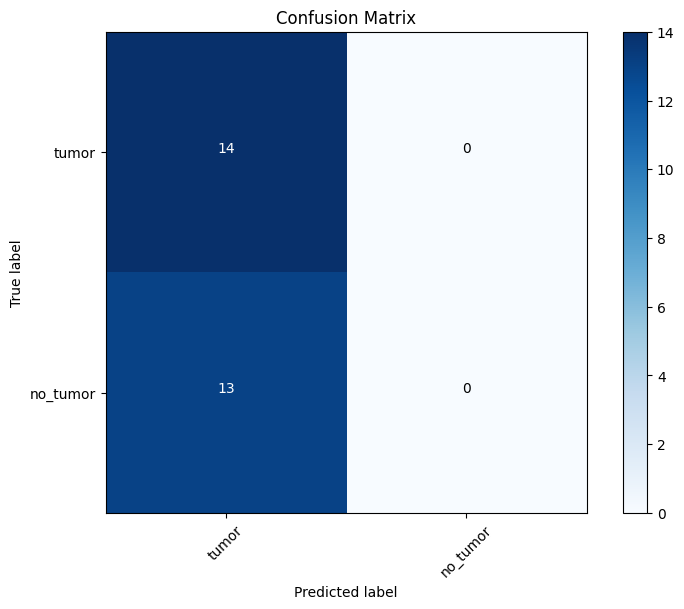

Baseline model saved to ..\src\models\supervised\baseline_model.keras

Running hyperparameter experiments:


========== Running experiment: Baseline ==========
Epoch 1/5
4/4 [==============================] - 35s 8s/step - loss: 6.3228 - accuracy: 0.4880 - val_loss: 0.6909 - val_accuracy: 0.5185
Epoch 2/5
4/4 [==============================] - 33s 8s/step - loss: 3.1133 - accuracy: 0.5120 - val_loss: 0.6905 - val_accuracy: 0.5185
Epoch 3/5
4/4 [==============================] - 32s 8s/step - loss: 2.3378 - accuracy: 0.6160 - val_loss: 0.6910 - val_accuracy: 0.5926
Epoch 4/5
4/4 [==============================] - 33s 8s/step - loss: 1.6623 - accuracy: 0.6720 - val_loss: 0.6931 - val_accuracy: 0.4815
Epoch 5/5
1/1 [==============================] - 2s 2s/step - loss: 0.6917 - accuracy: 0.5185
Model saved to ..\src\models\supervised\model_Baseline.keras


========== Running experiment: Deep ==========
Epoch 1/5
4/4 [==============================] - 42s 10s/step - loss: 1.7344 - accuracy:

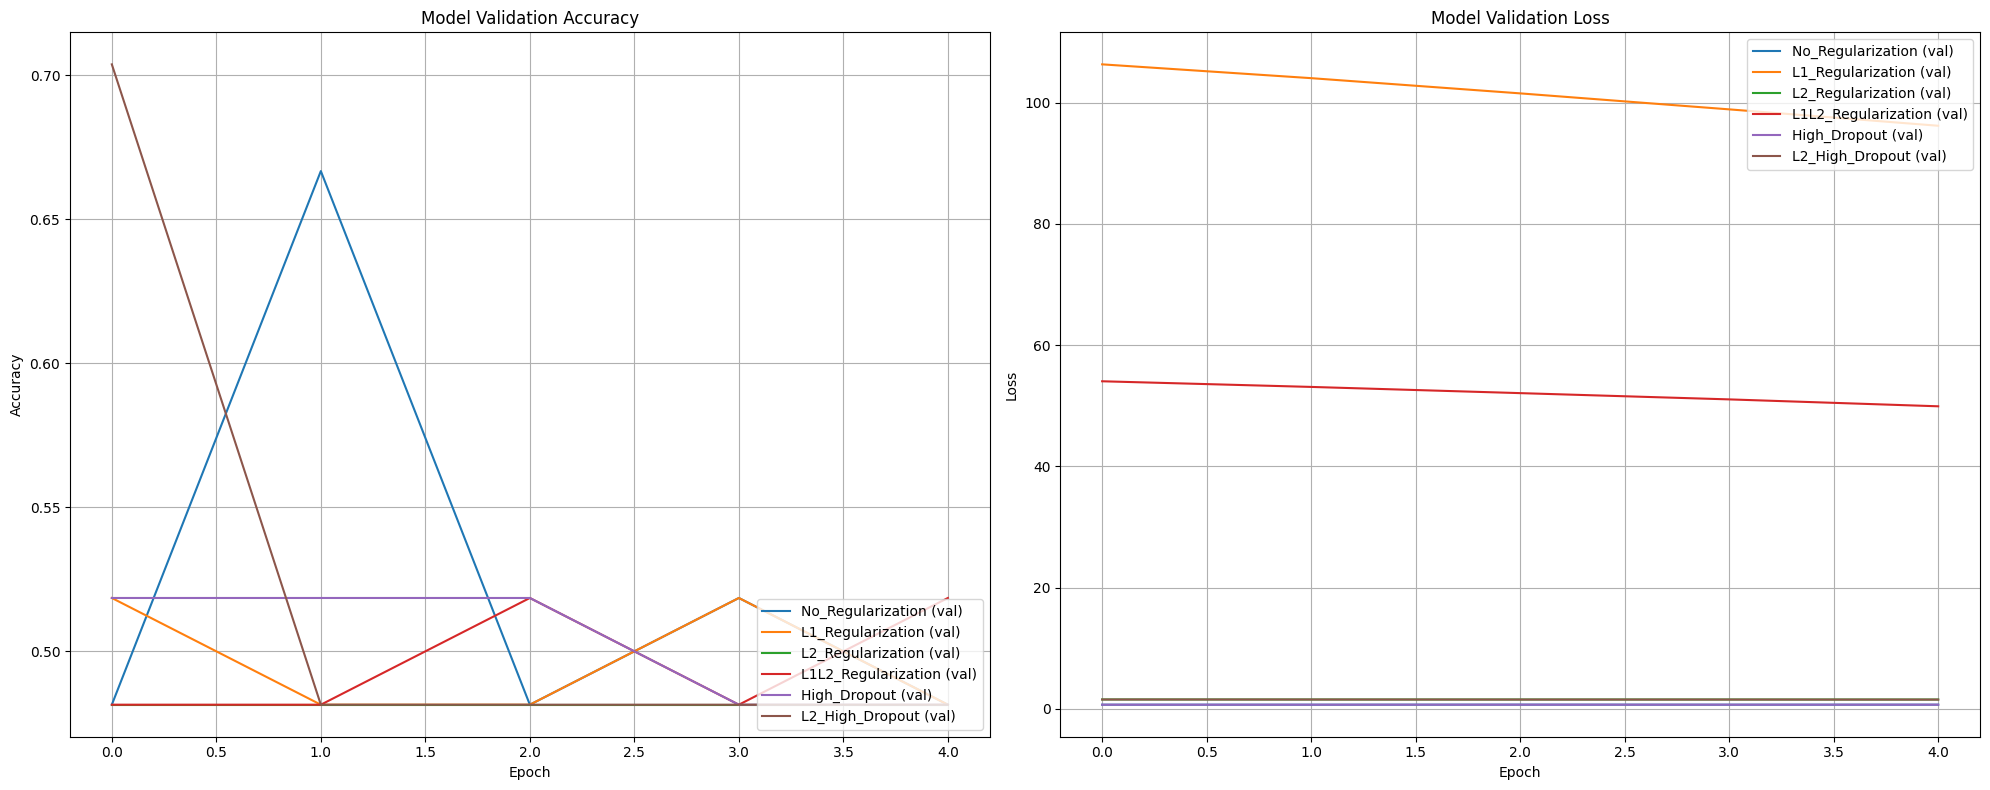

In [144]:
# Main execution
if __name__ == "__main__":
    # Create and train baseline model
    print("Creating and training baseline model...")
    baseline_model = create_model_variant(
        input_shape=(224, 224, 1),
        num_conv_layers=3,
        filters=32,
        kernel_size=3,
        dropout_rate=0.5,
        dense_units=256,
        learning_rate=0.0001
    )
    
    # Display model summary
    baseline_model.summary()
    
    # Train the model
    baseline_history = baseline_model.fit(
        train_data,
        validation_data=val_data,
        epochs=5,  # Start with fewer epochs for testing
        verbose=1
    )
    
    # Evaluate baseline model
    print("\nEvaluating baseline model:")
    y_true, y_pred = evaluate_model(baseline_model, test_data)
    
    # Save baseline model in the models directory
    baseline_model_path = os.path.join(MODELS_DIR, "baseline_model.keras")
    baseline_model.save(baseline_model_path)
    print(f"Baseline model saved to {baseline_model_path}")
    
    # Run hyperparameter experiments (with fewer epochs for testing)
    print("\nRunning hyperparameter experiments:")
    results, histories = run_experiments(train_data, val_data, test_data, epochs=5)
    
    # Test regularization techniques
    print("\nTesting different regularization techniques:")
    reg_results, reg_histories = try_regularization_techniques(train_data, val_data, test_data, epochs=5)
    
    # Find best model configurations
    best_hyperparams = results.loc[results['test_accuracy'].idxmax()]
    best_regularization = reg_results.loc[reg_results['test_accuracy'].idxmax()]
    
    # print("\n\n========== Best Model Configurations ==========")
    # print(f"Best hyperparameter configuration: {best_hyperparams['name']}")
    # print(f"Test accuracy: {best_hyperparams['test_accuracy']:.4f}")
    # print(f"Parameters: {best_hyperparams['params']}")
    
    # print(f"\nBest regularization technique: {best_regularization['name']}")
    # print(f"Test accuracy: {best_regularization['test_accuracy']:.4f}")
    # print(f"Parameters: {best_regularization['params']}")

    # Save summary of best models
    with open(os.path.join(RESULTS_DIR, "best_models_summary.txt"), "w") as f:
        f.write("========== Best Model Configurations ==========\n")
        f.write(f"Best hyperparameter configuration: {best_hyperparams['name']}\n")
        f.write(f"Test accuracy: {best_hyperparams['test_accuracy']:.4f}\n")
        f.write(f"Parameters: {str(best_hyperparams['params'])}\n\n")
        
        f.write(f"Best regularization technique: {best_regularization['name']}\n")
        f.write(f"Test accuracy: {best_regularization['test_accuracy']:.4f}\n")
        f.write(f"Parameters: {str(best_regularization['params'])}\n")